In [1]:
# initial set-up
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset
import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from utilities3 import *

from Adam import Adam
from sewar.full_ref import rmse, uqi
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

torch.manual_seed(0)
np.random.seed(0)

c:\Users\azhir\anaconda3\envs\gundam\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#  CONFIGURATIONS - HYPER PARAMETERS
################################################################
#  configurations - HYPER PARAMETERS
################################################################

batch_size = 10
learning_rate = 0.001

epochs = 100
step_size = 50
gamma = 0.5

modes = 5
width = 64

weight_decay=1e-4

# Hyperparameters to change - epoch{10,100,200}, step_size{}, batchsize{}, gamma{}, modes{}, weight_decay{}

In [9]:
#   DEFINING THE TOP 2D FOURIER LAYER
#####################################################################
#   DEFINING THE TOP 2D FOURIER LAYER

class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        #print('input',input.shape)
        #print('weights',weights.shape)
        #print("bixy,ioxy->boxy")
        R_out = torch.einsum("bixy,ioxy->boxy", input, weights)
        #print(R_out.shape)
        return R_out

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        #print('what is out_ft', out_ft.shape)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)
        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

In [40]:
class FNO2d(nn.Module):
    def __init__(self, modes1, modes2,  width):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        
        #self.padding = 16 # pad the domain if input is non-periodic
        #self.fc0 = nn.Linear(3, self.width) # input channel is 3: (a(x, y), x, y)
        

        #nn.Conv2d(in_channels = 1, out_channels = self.width, kernel_size = (3,3), stride=(3,3), padding=0)
        
        self.fc0 = nn.Linear(1, self.width)
        
        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)
        
        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128,2) 

        #self.fc1 = nn.Linear(self.width, 128)
        #self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        #grid = self.get_grid(x.shape, x.device)
        #print('x grid input shape', x.shape, 'grid input shape', grid.shape)
        #x = torch.cat((x, grid), dim=-1)
        #print('input shape',x.shape)
        #print('fc01 input is ', x.shape)
        x = self.fc0(x)
        #print('fc01 output is ', x.shape)
        #x = self.fc02(x)
        #print('fc0 shape',x.shape)
        x = x.permute(0, 3, 1, 2)
        #x = F.pad(x, [0,self.padding, 0,self.padding])

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2
        #print('FNO output shape', x.shape)
        #x = x[..., :-self.padding, :-self.padding]
        x = x.permute(0, 2, 3, 1)
        
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x
    '''
    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)
    '''

In [16]:
# DATA LOADING
############################## DATA LOADING ########################################
raw_data = scipy.io.loadmat('./datasets/training_data_16x16_10k')

sol = np.asarray(raw_data['solution_data'])
mes = np.asarray(raw_data['measurement_data'])

sol_temp = np.expand_dims(sol,axis = 1 )
#sol_temp = np.sqeeze(sol_temp)
mes_temp = np.transpose(np.expand_dims(mes,axis = 1 ),(0,2,1))

# dimensions of solution space
y_dim1 = 16
y_dim2 = 16

# dimensions of measurement space
x_dim2 = 8     # no of detectors
x_dim1 = int(mes.shape[1]/x_dim2)

def convert_data(data_x, data_y):
    data_X = torch.from_numpy(data_x).float()
    data_Y = torch.from_numpy(data_y).float()
    return data_X, data_Y

# we are solving the inverse problem, so going from measurements, to solutions
X, y = convert_data(mes_temp, sol_temp)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#y_normalizer = UnitGaussianNormalizer(y_train)
#y_train = y_normalizer.encode(y_train)

#x_normalizer = UnitGaussianNormalizer(X_train)
#X_train = x_normalizer.encode(X_train)
#X_test = x_normalizer.encode(X_test)

y_train = y_train.squeeze()
y_test = y_test.squeeze()

y_test = y_test.reshape(y_test.shape[0],y_dim1,y_dim2,1)
y_train = y_train.reshape(y_train.shape[0],y_dim1,y_dim2,1)

X_test = X_test.reshape(X_test.shape[0], x_dim1,x_dim2,1)
X_train = X_train.reshape(X_train.shape[0], x_dim1,x_dim2,1)

#batch_size = 10
#train_loader = DataLoader(data_utils.TensorDataset(X_train, Y_train), batch_size=batch_size, shuffle=True)
train_dataset = TensorDataset( X_train, y_train )
test_dataset = TensorDataset( X_test, y_test )

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

ntrain = X_train.shape[0]
ntest = X_test.shape[0]

In [3]:
# MODEL METRICS
###################################
# MODEL METRICS
###################################
def model_metrics(model,test_loader,ntrain):
    rms_values, psnr_values, ssim_values, uqi_values = [], [], [], []

    for test_num in range(ntest):
        K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
        model.eval()
        predicted_np = np.reshape(model(K).detach().cpu().numpy(),(16,16))

        truth = test_loader.dataset[test_num][1]
        truth_np = np.reshape(truth.numpy(),(16,16))

        #diff_image = predicted - truth_np
        #np.sqrt(np.sum(diff_image**2)/256)

        rms_values.append(rmse(predicted_np, truth_np))
        psnr_values.append(psnr(truth_np, predicted_np, data_range=predicted_np.max() - predicted_np.min()))
        ssim_values.append(ssim(truth_np, predicted_np, data_range=predicted_np.max() - predicted_np.min()))
        uqi_values.append(uqi(predicted_np, truth_np))

    model_rms = sum(rms_values)/ len(rms_values)
    std_rms = np.std(np.array(rms_values))

    model_psnr = sum(psnr_values)/ len(psnr_values)
    std_psnr = np.std(np.array(psnr_values))

    model_ssim = sum(ssim_values)/ len(ssim_values)
    std_ssim = np.std(np.array(ssim_values))

    model_uqi = sum(uqi_values)/ len(uqi_values)
    std_uqi = np.std(np.array(uqi_values))


    print("RMSE: ", model_rms, std_rms, sep="---")
    print("PSNR: ", model_psnr, std_psnr, sep="---")
    print("SSIM: ", model_ssim, std_ssim, sep="---")
    print("UQI: ", model_uqi, std_uqi, sep="---")


    output = {
    "rms": rms_values,
    "psnr": psnr_values,
    "ssim": ssim_values,
    "uqi": uqi_values,
    }
    return output 

In [18]:
# TRAINING AND EVALUATION
################################################################
# TRAINING AND EVALUATION
################################################################


def train_model(model, epochs, batch_size, learning_rate, weight_decay, step_size, gamma):
    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    train_losses, test_losses, epoch_time = [], [], []

    myloss = LpLoss(size_average=False)
    for ep in range(epochs):
        model.train()
        t1 = default_timer()
        train_mse = 0
        train_l2 = 0
        total_time = 0
        for x, y in train_loader:
            x, y = x.cuda(), y.cuda()

            optimizer.zero_grad()
            #print('in: ',x.shape)
            out = model(x)
            #print('out: ',out.shape)

            mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
            l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
            l2.backward() # use the l2 relative loss

            optimizer.step()
            train_mse += mse.item()
            train_l2 += l2.item()

        scheduler.step()
        model.eval()
        test_l2 = 0.0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.cuda(), y.cuda()

                out = model(x)
                test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

        #train_mse /= len(train_loader)
        train_l2 /= ntrain
        train_losses.append(train_l2)
        test_l2 /= ntest
        test_losses.append(test_l2)


        t2 = default_timer()
        epoch_time.append(t2 - t1)

        print(ep, t2 - t1, train_l2, test_l2)
    total_time = sum(epoch_time)
    print("TOTAL TIME: ", total_time, sep="---")

    output = {
    "train_losses": train_losses,
    "test_losses": test_losses,
    "epoch_time": epoch_time,
    "training_time": total_time,
    "model": model
    }
    return output 
# torch.save(model, 'model/ns_fourier_burgers')

# scipy.io.savemat('pred/burger_test.mat', mdict={'pred': pred.cpu().numpy()})

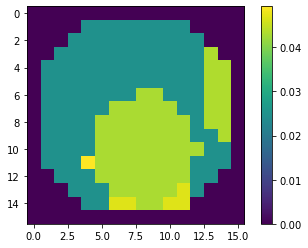

In [14]:
#Actual
test_num = 434
truth_out = test_loader.dataset[test_num][1]
plt.imshow(np.reshape(truth_out.numpy(),(16,16)))
plt.colorbar()

1663746
0 10.384201300010318 0.16595980900526047 0.13113018062710763
1 10.214385700004641 0.11583945138007402 0.10882403752207756
2 10.3076471999957 0.11203778012096882 0.1091093298792839
3 10.339908800000558 0.10721687015146017 0.10455874580144882
4 10.311077099991962 0.10479756604135036 0.10175826868414879
5 10.409697199997026 0.10169579430669547 0.09928280103206634
6 10.289003799989587 0.09901154286414385 0.09677361869812012
7 10.31408929999452 0.0970431022644043 0.0971595822274685
8 10.329275500000222 0.0954884826540947 0.09535647487640381
9 10.481695100010256 0.09429609427601099 0.09034001559019089
10 10.397065499986638 0.09209628655016422 0.09095734077692032
11 10.34287549999135 0.09180613316595554 0.08910501763224601
12 10.53200080001261 0.09052277833968402 0.08927509140968323
13 10.417242600000463 0.08951171687990427 0.09210266587138176
14 10.382150999997975 0.08821889398247004 0.08967437943816185
15 10.314564600004815 0.08778730461001397 0.08782569763064385
16 10.3193139000068

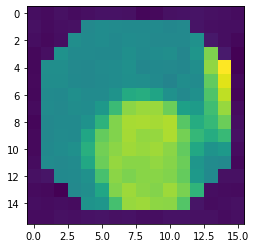

In [41]:
# TEST NETWORK
############################################################################

model_1L = FNO2d(modes, modes, width).cuda()
print(count_params(model_1L))
output_1L = train_model(model_1L, 20, batch_size, learning_rate, weight_decay, step_size, gamma)

output_1L_model = output_1L.get("model")
torch.save(output_1L_model, 'fno2D_1l.h5')
results_1L = model_metrics(output_1L_model,test_loader,ntrain)

# TEST NETWORK RESULTS
############################################################################
K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
output_1L_model.eval()
predicted = np.reshape(output_1L_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)

# Gauss Newton Analysis

In [13]:
gn_raw_data = scipy.io.loadmat('./datasets/gn_recon2')

truth_gn = np.asarray(gn_raw_data['solution_data'])
recon_gn = np.asarray(gn_raw_data['inv_data'])


In [14]:
gn_metrics = basic_metrics(truth_gn,recon_gn,1049)

RMSE: ---0.0023325741778058885---0.00118719070124515
PSNR: ---27.17938077005026---3.252518004729929
SSIM: ---0.9112616581791761---0.029275127298250662
UQI: ---0.9957178636222133---0.0033051194141654285


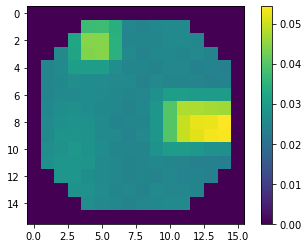

In [15]:
test_num = 1000
inv_np = np.reshape(recon_gn[test_num,:],(16,16))
plt.imshow(inv_np)
plt.colorbar()

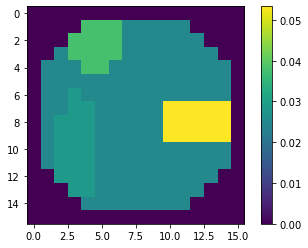

In [16]:
predicted_np = np.reshape(truth_gn[test_num,:],(16,16))
plt.imshow(predicted_np)
plt.colorbar()

In [17]:
# MODEL METRICS
###################################
# MODEL METRICS
###################################
def basic_metrics(recon_data,true_data, no_recon):
    rms_values, psnr_values, ssim_values, uqi_values = [], [], [], []

    for test_num in range(no_recon):
        predicted_np = np.reshape(recon_data[test_num,:],(16,16))
        truth_np = np.reshape(true_data[test_num,:],(16,16))

        rms_values.append(rmse(predicted_np, truth_np))
        psnr_values.append(psnr(truth_np, predicted_np, data_range=predicted_np.max() - predicted_np.min()))
        ssim_values.append(ssim(truth_np, predicted_np, data_range=predicted_np.max() - predicted_np.min()))
        uqi_values.append(uqi(predicted_np, truth_np))

    model_rms = sum(rms_values)/ len(rms_values)
    std_rms = np.std(np.array(rms_values))

    model_psnr = sum(psnr_values)/ len(psnr_values)
    std_psnr = np.std(np.array(psnr_values))

    model_ssim = sum(ssim_values)/ len(ssim_values)
    std_ssim = np.std(np.array(ssim_values))

    model_uqi = sum(uqi_values)/ len(uqi_values)
    std_uqi = np.std(np.array(uqi_values))


    print("RMSE: ", model_rms, std_rms, sep="---")
    print("PSNR: ", model_psnr, std_psnr, sep="---")
    print("SSIM: ", model_ssim, std_ssim, sep="---")
    print("UQI: ", model_uqi, std_uqi, sep="---")


    output = {
    "rms": rms_values,
    "psnr": psnr_values,
    "ssim": ssim_values,
    "uqi": uqi_values,
    }
    return output 

<function matplotlib.pyplot.show(close=None, block=None)>

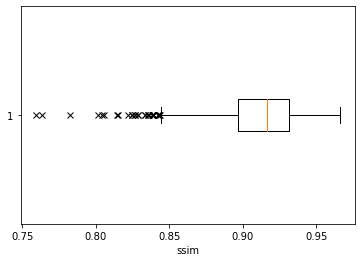

In [72]:

metric_type = 'ssim'         # can be the following rms, ssim, psnr

fig1, ax1 = plt.subplots()
red_cross = dict(markerfacecolor='r', marker='x')
data = (gn_metrics.get(metric_type))

ax1.boxplot(data, vert=False, flierprops=red_cross)
plt.xlabel(metric_type)
plt.show

#plt.savefig('./images/gn_'+'boxplot_'+str(metric_type))

In [73]:
# Create outlier range
q75, q25 = np.percentile(data, [75 ,25])
iqr = q75 - q25
outliers = [q25-1.5*iqr,q75+1.5*iqr]

# zip data
data_no = range(len(data))
listed_data = zip(data_no,data)

data_list = list(listed_data)



print('outliers are anything below ',outliers[0],' or above ',outliers[1])

outlier_list = []
for i in range(len(data)):
    if data_list[i][1] < outliers[0]:
        outlier_list.append(data_list[i])
    elif data_list[i][1] > outliers[1]:
        outlier_list.append(data_list[i])


outliers are anything below  0.844219949680806  or above  0.9842195745120514


In [74]:
print('the number of outliers are ',len(outlier_list) )
#worst reconstruction
worst = [np.min(np.asarray(outlier_list)[:,1]), np.max(np.asarray(outlier_list)[:,1]) ]
print('for outliers, the lowest metric value is ',worst[0],' and highest is', worst[1])

# The values for the worst performers! 
for i in range(len(outlier_list)):
    if outlier_list[i][1] ==  worst[0]:
        print(outlier_list[i])
    elif outlier_list[i][1] == worst[1]:
        print(outlier_list[i])


the number of outliers are  35
for outliers, the lowest metric value is  0.7593013421315566  and highest is 0.8439808814369333
(638, 0.7593013421315566)
(667, 0.8439808814369333)


In [75]:
print(outlier_list)

[(7, 0.8388732765756991), (37, 0.8388942846076697), (70, 0.8248337799820034), (89, 0.8422858144196317), (114, 0.8387554376111701), (154, 0.8223512516714632), (162, 0.8152994771019019), (196, 0.8428190983392011), (239, 0.8336102931534046), (299, 0.8388855749068316), (310, 0.8143280484017714), (375, 0.7632014283413971), (463, 0.8384971556101967), (472, 0.8357962839866224), (482, 0.8388066610822886), (487, 0.8018478236835995), (495, 0.8285488596078803), (534, 0.8365652252825854), (535, 0.8043690335214135), (595, 0.8268336137461725), (623, 0.7824336808334823), (633, 0.8392277153853941), (638, 0.7593013421315566), (645, 0.8388975253957822), (662, 0.828901862720836), (667, 0.8439808814369333), (776, 0.8353833930572372), (830, 0.8250335865273236), (871, 0.842580944104659), (896, 0.8388864853201099), (918, 0.842808501778314), (933, 0.8059715381560314), (971, 0.8338494442383952), (1029, 0.8389178662413624), (1046, 0.8268300111156752)]


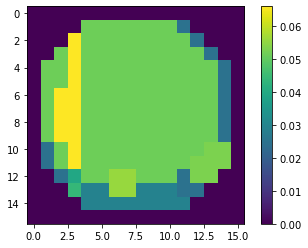

In [92]:
#Actual
name = 'gn_'
test_num = 638

predicted_np = np.reshape(truth_gn[test_num,:],(16,16))
plt.imshow(predicted_np)
plt.colorbar()

save_truth = name + metric_type + str(test_num)
plt.savefig('./images/'+save_truth)

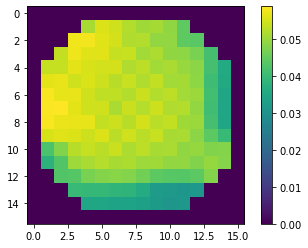

In [93]:
# Quickly showing that our model gives expected results. 
inv_np = np.reshape(recon_gn[test_num,:],(16,16))
plt.imshow(inv_np)
plt.colorbar()

save_recon = save_truth + '_recon'
plt.savefig('./images/' + save_recon)